In [1]:
!pip install qiskit==1.4.1 qiskit_machine_learning qiskit_aer qiskit_ibm_runtime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.9 MB/s eta 0:00:00


Client 1: 30 samples → 24 train, 6 local test
Client 2: 30 samples → 24 train, 6 local test
Client 3: 30 samples → 24 train, 6 local test
Starting Federated Learning: 3 clients, 10 rounds

--- Round 1/10 ---
  Client 1/3: training on 24 samples...
  Quantum VQC on the training dataset: 0.5417
  Quantum VQC on the test dataset:     0.5000
  Client 2/3: training on 24 samples...
  Quantum VQC on the training dataset: 0.6250
  Quantum VQC on the test dataset:     0.6667
  Client 3/3: training on 24 samples...
  Quantum VQC on the training dataset: 0.2917
  Quantum VQC on the test dataset:     0.3333
  Aggregated global weights (FedAvg)
  Global Test Accuracy: 0.3333

--- Round 2/10 ---
  Client 1/3: training on 24 samples...
  Quantum VQC on the training dataset: 0.5417
  Quantum VQC on the test dataset:     0.5000
  Client 2/3: training on 24 samples...
  Quantum VQC on the training dataset: 0.6250
  Quantum VQC on the test dataset:     0.6667
  Client 3/3: training on 24 samples...
  Qu

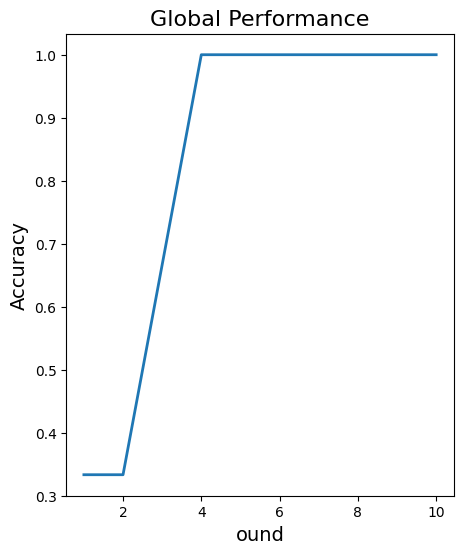

In [31]:
# ---------------------------------------------------------------------------------------------------------------------------------------#
# Just simple toy implementation of federation for quantum machine learning by Dev Gurung, Deakin University
# Various Resources are being used and the links provided:
# Main Resource referenced: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html
# For further detail, quantum machine learning https://qiskit-community.github.io/qiskit-machine-learning/getting_started.html
# ---------------------------------------------------------------------------------------------------------------------------------------#

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from sklearn.metrics import accuracy_score, log_loss
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from sklearn.preprocessing import MinMaxScaler
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#Transpile required for execucation on real hardware
#https://quantum.cloud.ibm.com/docs/en/api/qiskit/transpiler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeBrisbane
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister


# 1. PREPARE DATA https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

# You can select the labels, customize your experiment
mask = labels < 2
features = features[mask]
labels = labels[mask]

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.9, random_state=42)


#https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html
# Design or Select Classifier
# Here we are using NeuralNetworkClassifier with SamplerQNN; We need FeatureMap and Ansatz
num_features = features.shape[1]
#The ZFeatureMap is one of feature maps in the Qiskit circuit library. We pass num_features as feature_dimension, meaning the feature map will have num_features or 4 qubits.
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.measure_all() #measurement operation to all qubits
backend = AerSimulator()
sampler = Sampler(mode=backend)

optimizer = COBYLA(maxiter=10)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
input_params = feature_map.parameters
weight_params = ansatz.parameters

# Compose the feature map and ansatz
qc = QuantumCircuit(num_features)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Define a custom interpret function that calculates the parity of the bitstring
# function that takes a bitstring (represented as an integer) and returns its parity. The parity is typically defined as 0 if the number of '1's in the bitstring is even, and 1 if it's odd.
def parity(x):
    return f"{bin(x)}".count("1") % 2

# https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params,
    sampler=sampler,
    output_shape=2,
    gradient=None,
    interpret=parity,
    pass_manager=pm
)


# Define number of clients, how many rounds and local iteration
n_clients = 3
federated_rounds = 10
local_maxiter = 5
# When it is set to True and fit() is called again the model uses weights from previous fit to start a new fit.
check = True #start from previously optimized state

# Randomize dataset
indices = np.random.permutation(len(X_train))
X_shuffled = X_train[indices]
y_shuffled = y_train[indices]
X_splits = np.array_split(X_shuffled, n_clients)
y_splits = np.array_split(y_shuffled, n_clients)

from sklearn.model_selection import train_test_split

clients = []

for i in range(n_clients):
    X_client = X_splits[i]
    y_client = y_splits[i].astype(int)

    # Further split data withint device to calculate local and test accuracy for devices
    X_train, X_test, y_train, y_test = train_test_split(
        X_client,
        y_client,
        train_size=0.8,
        stratify=y_client
    )

    classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=local_maxiter),
        warm_start=check
    )


    clients.append({
        'id': i,
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,
        'model': classifier,
        'train_scores': [],
        'test_scores':  [],
        'training_times': [],
        'n_total_samples': len(X_client),
        'n_train_samples': len(X_train),
        'n_test_samples':  len(X_test)
    })

    print(f"Client {i+1}: {len(X_client)} samples → "
          f"{len(X_train)} train, {len(X_test)} local test")

global_weights = None
global_accuracies = []
print(f"Starting Federated Learning: {n_clients} clients, {federated_rounds} rounds\n")


for round_num in range(1, federated_rounds + 1):
    print(f"--- Round {round_num}/{federated_rounds} ---")

    client_weights = []

    for client in clients:
        print(f"  Client {client['id']+1}/{n_clients}: training on {len(client['X_train'])} samples...")
        if round_num > 0:
          #continue training from that point by setting initial_point to a vector of pre-trained weights.
          # https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html
          client['model'].initial_point = global_weights
        client['model'].fit(client['X_train'], client['y_train'])
        train_score = client['model'].score(client['X_train'], client['y_train'])
        test_score = client['model'].score(client['X_test'], client['y_test'])
        client['train_scores'].append(train_score)
        client['test_scores'].append(test_score)
        print(f"  Quantum VQC on the training dataset: {train_score:.4f}")
        print(f"  Quantum VQC on the test dataset:     {test_score:.4f}")
        client_weights.append(client['model'].weights)

    global_weights = np.mean(client_weights, axis=0)
    print(f"  Aggregated global weights (FedAvg)")

    probs = sampler_qnn.forward(X_test, global_weights)
    y_pred = np.argmax(probs, axis=1)
    acc = accuracy_score(y_test, y_pred)
    global_accuracies.append(acc)
    print(f"  Global Test Accuracy: {acc:.4f}\n")


print(f"Final Global Accuracy: {global_accuracies[-1]:.4f}")

plt.figure(figsize=(5, 6))
plt.plot(range(1, federated_rounds + 1), global_accuracies, linewidth=2)
plt.title("Global Performance", fontsize=16)
plt.xlabel("Round", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.show()


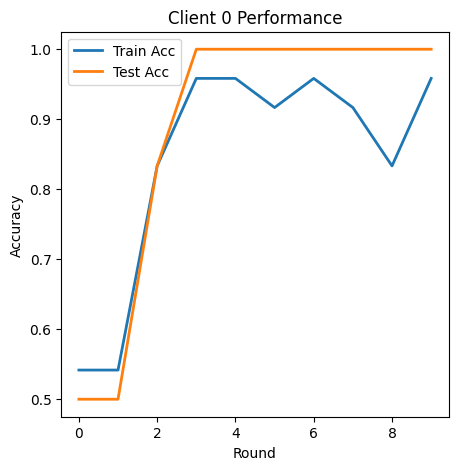

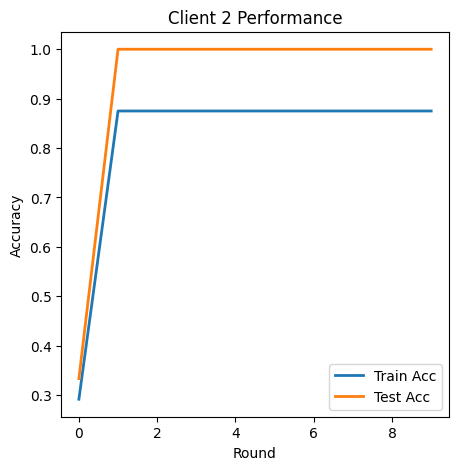

In [36]:
client = clients[0]

plt.figure(figsize=(5, 5))
plt.plot(client['train_scores'], label='Train Acc', linewidth=2)
plt.plot(client['test_scores'], label='Test Acc',  linewidth=2)
plt.title(f"Client {client['id']} Performance")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

client = clients[2]

plt.figure(figsize=(5, 5))
plt.plot(client['train_scores'], label='Train Acc', linewidth=2)
plt.plot(client['test_scores'], label='Test Acc',  linewidth=2)
plt.title(f"Client {client['id']} Performance")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.show()